In [599]:
from datetime import datetime
import requests
from io import StringIO
import json

import pandas as pd
import geopandas as gpd
import numpy as np
from functools import reduce

import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point


# Analyzing Aggravated Burglaries in Davidson County

1. A dataset containing details about Metro Nashville Police Department reported incidents is available at https://data.nashville.gov/Police/Metro-Nashville-Police-Department-Incidents/2u6v-ujjs. Make use of the API to find all aggravated burglary incidents that were reported during the six month period from January 1, 2021 through June 30, 2021.


In [600]:
import requests

In [601]:
endpoint = 'https://data.nashville.gov/resource/2u6v-ujjs.json'


In [602]:
params = {'offense_description' : 'BURGLARY- AGGRAVATED', '$where': "incident_reported between '2021-01-01' and '2021-06-30'", '$limit': 50000}


In [603]:
response = requests.get(endpoint, params)

In [604]:
#response.text

In [605]:
from io import StringIO # turn strings to DF

In [606]:
burglaries = pd.read_json(StringIO(response.text))


In [607]:
burglaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046 entries, 0 to 1045
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   primary_key                  1046 non-null   int64  
 1   incident_number              1046 non-null   int64  
 2   report_type                  1046 non-null   object 
 3   report_type_description      1034 non-null   object 
 4   incident_status_code         1046 non-null   object 
 5   incident_status_description  1046 non-null   object 
 6   investigation_status         1046 non-null   object 
 7   incident_occurred            1046 non-null   object 
 8   incident_reported            1046 non-null   object 
 9   incident_location            1044 non-null   object 
 10  latitude                     1044 non-null   float64
 11  longitude                    1044 non-null   float64
 12  rpa                          964 non-null    float64
 13  zone              

In [608]:
#burglaries.columns
for col in census.columns:
    print(col)

burglaries.dropna(subset = ['latitude', 'longitude'])

STATEFP
COUNTYFP
TRACTCE
GEOID
NAME
NAMELSAD
MTFCC
FUNCSTAT
ALAND
AWATER
INTPTLAT
INTPTLON
geometry


,primary_key,incident_number,report_type,report_type_description,incident_status_code,incident_status_description,investigation_status,incident_occurred,incident_reported,incident_location,...,victim_number,domestic_related,victim_type,victim_description,victim_gender,victim_race,victim_ethnicity,victim_county_resident,mapped_location,zip_code
0,2021024954011,20210249540,D,DISPATCHED,O,OPEN,Open,2021-05-04T23:45:00.000,2021-05-05T00:45:00.000,UNIVERSITY CT,...,1,False,I,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.77, 36.15]}",NaN
1,2021024884011,20210248840,D,DISPATCHED,O,OPEN,Open,2021-05-04T12:06:00.000,2021-05-04T14:33:00.000,BONNAFAIR DR,...,1,False,I,INDIVIDUAL (18 AND OVER),F,W,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.63, 36.2]}",NaN
2,2021024491911,20210244919,D,DISPATCHED,O,OPEN,Open,2021-05-01T23:00:00.000,2021-05-02T12:40:00.000,8TH AVE S,...,1,False,I,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,NON RESIDENT,"{'type': 'Point', 'coordinates': [-86.78, 36.14]}",NaN
3,2021024489213,20210244892,D,DISPATCHED,O,OPEN,Open,2021-05-01T21:30:00.000,2021-05-02T11:57:00.000,EAST ARGYLE AVE,...,3,False,I,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,NON RESIDENT,"{'type': 'Point', 'coordinates': [-86.78, 36.14]}",NaN
4,2021024954012,20210249540,D,DISPATCHED,O,OPEN,Open,2021-05-04T23:45:00.000,2021-05-05T00:45:00.000,UNIVERSITY CT,...,2,False,I,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.77, 36.15]}",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,2021002931311,20210029313,D,DISPATCHED,A,CLEARED BY ARREST,Closed,2021-01-15T21:50:00.000,2021-01-16T02:36:00.000,804 804,...,1,False,I,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.647, 36....",37013.0
1042,2021007378711,20210073787,D,DISPATCHED,A,CLEARED BY ARREST,Closed,2021-02-06T12:00:00.000,2021-02-06T18:19:00.000,33 33,...,1,True,I,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.765, 36....",37210.0
1043,2021012791511,20210127915,D,DISPATCHED,A,CLEARED BY ARREST,Closed,2021-03-03T15:30:00.000,2021-03-05T13:33:00.000,804 804,...,1,False,I,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.807, 36....",37207.0
1044,2021012655111,20210126551,O,NaN,O,OPEN,Open,2021-02-23T10:30:00.000,2021-03-03T23:12:00.000,NOLENSVILLE PIKE,...,1,False,B,BUSINESS,NaN,NaN,NaN,NaN,"{'type': 'Point', 'coordinates': [-86.72, 36.05]}",NaN



2. Download the 2019 census tract shapefiles for Tennessee from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2019.html. (The FIPS code for Tennessee is 47). Perform a spatial join to determine the census tract in which each burglary incident occurred. Which census tract had the highest number of burglaries? Warning - each incident can appear multiple times if there are multiple victims, so be sure that you aren't double-counting any incidents.



In [609]:
burglaries.drop_duplicates(subset = 'incident_number')

,primary_key,incident_number,report_type,report_type_description,incident_status_code,incident_status_description,investigation_status,incident_occurred,incident_reported,incident_location,...,victim_number,domestic_related,victim_type,victim_description,victim_gender,victim_race,victim_ethnicity,victim_county_resident,mapped_location,zip_code
0,2021024954011,20210249540,D,DISPATCHED,O,OPEN,Open,2021-05-04T23:45:00.000,2021-05-05T00:45:00.000,UNIVERSITY CT,...,1,False,I,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.77, 36.15]}",NaN
1,2021024884011,20210248840,D,DISPATCHED,O,OPEN,Open,2021-05-04T12:06:00.000,2021-05-04T14:33:00.000,BONNAFAIR DR,...,1,False,I,INDIVIDUAL (18 AND OVER),F,W,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.63, 36.2]}",NaN
2,2021024491911,20210244919,D,DISPATCHED,O,OPEN,Open,2021-05-01T23:00:00.000,2021-05-02T12:40:00.000,8TH AVE S,...,1,False,I,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,NON RESIDENT,"{'type': 'Point', 'coordinates': [-86.78, 36.14]}",NaN
3,2021024489213,20210244892,D,DISPATCHED,O,OPEN,Open,2021-05-01T21:30:00.000,2021-05-02T11:57:00.000,EAST ARGYLE AVE,...,3,False,I,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,NON RESIDENT,"{'type': 'Point', 'coordinates': [-86.78, 36.14]}",NaN
5,2021024840212,20210248402,D,DISPATCHED,O,OPEN,Open,2021-05-04T00:00:00.000,2021-05-04T09:50:00.000,NEESE DR,...,2,False,I,INDIVIDUAL (18 AND OVER),F,W,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.73, 36.11]}",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,2021002931311,20210029313,D,DISPATCHED,A,CLEARED BY ARREST,Closed,2021-01-15T21:50:00.000,2021-01-16T02:36:00.000,804 804,...,1,False,I,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.647, 36....",37013.0
1042,2021007378711,20210073787,D,DISPATCHED,A,CLEARED BY ARREST,Closed,2021-02-06T12:00:00.000,2021-02-06T18:19:00.000,33 33,...,1,True,I,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.765, 36....",37210.0
1043,2021012791511,20210127915,D,DISPATCHED,A,CLEARED BY ARREST,Closed,2021-03-03T15:30:00.000,2021-03-05T13:33:00.000,804 804,...,1,False,I,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.807, 36....",37207.0
1044,2021012655111,20210126551,O,NaN,O,OPEN,Open,2021-02-23T10:30:00.000,2021-03-03T23:12:00.000,NOLENSVILLE PIKE,...,1,False,B,BUSINESS,NaN,NaN,NaN,NaN,"{'type': 'Point', 'coordinates': [-86.72, 36.05]}",NaN


In [610]:
type(burglaries)

pandas.core.frame.DataFrame

In [642]:

burglaries['geometry'] = burglaries.apply(lambda x: Point((x['longitude'], 
                                                         x['latitude'])), 

                                        axis=1) # what is axis here?

In [612]:
burglaries.drop(columns = ['longitude', 'latitude'])

,primary_key,incident_number,report_type,report_type_description,incident_status_code,incident_status_description,investigation_status,incident_occurred,incident_reported,incident_location,...,domestic_related,victim_type,victim_description,victim_gender,victim_race,victim_ethnicity,victim_county_resident,mapped_location,zip_code,geometry
0,2021024954011,20210249540,D,DISPATCHED,O,OPEN,Open,2021-05-04T23:45:00.000,2021-05-05T00:45:00.000,UNIVERSITY CT,...,False,I,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.77, 36.15]}",NaN,POINT (-86.77 36.15)
1,2021024884011,20210248840,D,DISPATCHED,O,OPEN,Open,2021-05-04T12:06:00.000,2021-05-04T14:33:00.000,BONNAFAIR DR,...,False,I,INDIVIDUAL (18 AND OVER),F,W,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.63, 36.2]}",NaN,POINT (-86.63 36.2)
2,2021024491911,20210244919,D,DISPATCHED,O,OPEN,Open,2021-05-01T23:00:00.000,2021-05-02T12:40:00.000,8TH AVE S,...,False,I,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,NON RESIDENT,"{'type': 'Point', 'coordinates': [-86.78, 36.14]}",NaN,POINT (-86.78 36.14)
3,2021024489213,20210244892,D,DISPATCHED,O,OPEN,Open,2021-05-01T21:30:00.000,2021-05-02T11:57:00.000,EAST ARGYLE AVE,...,False,I,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,NON RESIDENT,"{'type': 'Point', 'coordinates': [-86.78, 36.14]}",NaN,POINT (-86.78 36.14)
4,2021024954012,20210249540,D,DISPATCHED,O,OPEN,Open,2021-05-04T23:45:00.000,2021-05-05T00:45:00.000,UNIVERSITY CT,...,False,I,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.77, 36.15]}",NaN,POINT (-86.77 36.15)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,2021002931311,20210029313,D,DISPATCHED,A,CLEARED BY ARREST,Closed,2021-01-15T21:50:00.000,2021-01-16T02:36:00.000,804 804,...,False,I,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.647, 36....",37013.0,POINT (-86.64700000000001 36.052)
1042,2021007378711,20210073787,D,DISPATCHED,A,CLEARED BY ARREST,Closed,2021-02-06T12:00:00.000,2021-02-06T18:19:00.000,33 33,...,True,I,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.765, 36....",37210.0,POINT (-86.765 36.152)
1043,2021012791511,20210127915,D,DISPATCHED,A,CLEARED BY ARREST,Closed,2021-03-03T15:30:00.000,2021-03-05T13:33:00.000,804 804,...,False,I,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.807, 36....",37207.0,POINT (-86.807 36.204)
1044,2021012655111,20210126551,O,NaN,O,OPEN,Open,2021-02-23T10:30:00.000,2021-03-03T23:12:00.000,NOLENSVILLE PIKE,...,False,B,BUSINESS,NaN,NaN,NaN,NaN,"{'type': 'Point', 'coordinates': [-86.72, 36.05]}",NaN,POINT (-86.72 36.05)


In [613]:
type(burglaries)

pandas.core.frame.DataFrame

In [614]:
# turn the df burglaries into a geo-df
geo_burglaries = gpd.GeoDataFrame(burglaries, crs = "EPSG:4269", geometry = burglaries['geometry'])

In [615]:
type(geo_burglaries)

geopandas.geodataframe.GeoDataFrame

In [616]:
census_tracts= gpd.read_file('../data/tl_2019_47_tract.shp')
census_tracts.head(2)


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,165,021002,47165021002,210.02,Census Tract 210.02,G5020,S,30654374,207994,+36.3521602,-086.6464309,"POLYGON ((-86.69927 36.32775, -86.69923 36.327..."
1,47,165,020901,47165020901,209.01,Census Tract 209.01,G5020,S,23811766,3412697,+36.3483143,-086.4070907,"POLYGON ((-86.43949 36.35962, -86.43915 36.359..."


In [617]:
census_tracts.to_crs('EPSG:4326') # the longiture/latitude system that is common
census_tracts.head(2)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,165,021002,47165021002,210.02,Census Tract 210.02,G5020,S,30654374,207994,+36.3521602,-086.6464309,"POLYGON ((-86.69927 36.32775, -86.69923 36.327..."
1,47,165,020901,47165020901,209.01,Census Tract 209.01,G5020,S,23811766,3412697,+36.3483143,-086.4070907,"POLYGON ((-86.43949 36.35962, -86.43915 36.359..."


In [618]:
type(census_tracts)

geopandas.geodataframe.GeoDataFrame

In [619]:
geo_burg_census = gpd.sjoin(geo_burglaries, census_tracts, op = "within")


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [620]:
geo_burg_census.head(2)
geo_burg_census.columns

Index(['primary_key', 'incident_number', 'report_type',
       'report_type_description', 'incident_status_code',
       'incident_status_description', 'investigation_status',
       'incident_occurred', 'incident_reported', 'incident_location',
       'latitude', 'longitude', 'rpa', 'zone', 'location_code',
       'location_description', 'offense_number', 'offense_nibrs',
       'offense_description', 'weapon_primary', 'weapon_description',
       'victim_number', 'domestic_related', 'victim_type',
       'victim_description', 'victim_gender', 'victim_race',
       'victim_ethnicity', 'victim_county_resident', 'mapped_location',
       'zip_code', 'geometry', 'index_right', 'STATEFP', 'COUNTYFP', 'TRACTCE',
       'GEOID', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON'],
      dtype='object')

In [621]:
census_tracts['NAMELSAD'].value_counts().nlargest()

Census Tract 9801    13
Census Tract 9702     7
Census Tract 9501     7
Census Tract 9601     6
Census Tract 9504     6
Name: NAMELSAD, dtype: int64

3. For this part, you'll need to request a [census API key](https://api.census.gov/data/key_signup.html). Using the [2019 American Community Survey API](https://www.census.gov/data/developers/data-sets/acs-5year.html), obtain, for each census tract, the population (B01001_001E in the detailed tables) and the median income (S1901_C01_012E in the subject tables). Hint: Tennessee's FIPS code is 47 and Davidson County's FIPS code is 37. Merge this new data with the burglaries data above.



In [622]:
endpoint = 'https://api.census.gov/data/2019/acs/acs5'

parameters = {'get': 'NAME,B01001_001E', 'for': 'tract:*', 'in' : 'state:47 county:037' } # get from population, get every tract *, tehn limit to TN davidson
  
response = requests.get(endpoint, params= parameters )

In [623]:
davidson_pop = pd.read_json(StringIO(response.text))

In [624]:
davidson_pop.head(5)


,0,1,2,3,4
0,NAME,B01001_001E,state,county,tract
1,"Census Tract 156.31, Davidson County, Tennessee",12176,47,037,015631
2,"Census Tract 158.04, Davidson County, Tennessee",4098,47,037,015804
3,"Census Tract 177.01, Davidson County, Tennessee",2466,47,037,017701
4,"Census Tract 177.02, Davidson County, Tennessee",5210,47,037,017702


In [625]:
davidson_pop.columns = davidson_pop.iloc[0]

In [626]:
davidson_pop

,NAME,B01001_001E,state,county,tract
0,NAME,B01001_001E,state,county,tract
1,"Census Tract 156.31, Davidson County, Tennessee",12176,47,037,015631
2,"Census Tract 158.04, Davidson County, Tennessee",4098,47,037,015804
3,"Census Tract 177.01, Davidson County, Tennessee",2466,47,037,017701
4,"Census Tract 177.02, Davidson County, Tennessee",5210,47,037,017702
...,...,...,...,...,...
157,"Census Tract 156.13, Davidson County, Tennessee",5252,47,037,015613
158,"Census Tract 156.20, Davidson County, Tennessee",7262,47,037,015620
159,"Census Tract 161, Davidson County, Tennessee",2345,47,037,016100
160,"Census Tract 114, Davidson County, Tennessee",4617,47,037,011400


In [627]:
davidson_pop = davidson_pop[1:] # do not rerun because this cuts every time!!!

In [628]:
davidson_pop

,NAME,B01001_001E,state,county,tract
1,"Census Tract 156.31, Davidson County, Tennessee",12176,47,037,015631
2,"Census Tract 158.04, Davidson County, Tennessee",4098,47,037,015804
3,"Census Tract 177.01, Davidson County, Tennessee",2466,47,037,017701
4,"Census Tract 177.02, Davidson County, Tennessee",5210,47,037,017702
5,"Census Tract 183.01, Davidson County, Tennessee",8254,47,037,018301
...,...,...,...,...,...
157,"Census Tract 156.13, Davidson County, Tennessee",5252,47,037,015613
158,"Census Tract 156.20, Davidson County, Tennessee",7262,47,037,015620
159,"Census Tract 161, Davidson County, Tennessee",2345,47,037,016100
160,"Census Tract 114, Davidson County, Tennessee",4617,47,037,011400


In [629]:

endpoint = 'https://api.census.gov/data/2018/acs/acs5/subject'

parameters = {'get': 'NAME,S1901_C01_012E', 'for': 'tract:*', 'in' : 'state:47 county:037' } # get from population, get every tract *, tehn limit to TN davidson
  
response = requests.get(endpoint, params= parameters )

In [630]:
davidson_inc = pd.read_json(StringIO(response.text))

In [631]:
davidson_inc

,0,1,2,3,4
0,NAME,S1901_C01_012E,state,county,tract
1,"Census Tract 133, Davidson County, Tennessee",51863,47,037,013300
2,"Census Tract 172, Davidson County, Tennessee",41463,47,037,017200
3,"Census Tract 184.08, Davidson County, Tennessee",115116,47,037,018408
4,"Census Tract 114, Davidson County, Tennessee",44492,47,037,011400
...,...,...,...,...,...
157,"Census Tract 109.03, Davidson County, Tennessee",35976,47,037,010903
158,"Census Tract 139, Davidson County, Tennessee",25521,47,037,013900
159,"Census Tract 189.01, Davidson County, Tennessee",53750,47,037,018901
160,"Census Tract 178, Davidson County, Tennessee",76014,47,037,017800


In [632]:
davidson_inc.columns = davidson_inc.iloc[0]

In [633]:
davidson_inc[1:]

,NAME,S1901_C01_012E,state,county,tract
1,"Census Tract 133, Davidson County, Tennessee",51863,47,037,013300
2,"Census Tract 172, Davidson County, Tennessee",41463,47,037,017200
3,"Census Tract 184.08, Davidson County, Tennessee",115116,47,037,018408
4,"Census Tract 114, Davidson County, Tennessee",44492,47,037,011400
5,"Census Tract 138, Davidson County, Tennessee",33118,47,037,013800
...,...,...,...,...,...
157,"Census Tract 109.03, Davidson County, Tennessee",35976,47,037,010903
158,"Census Tract 139, Davidson County, Tennessee",25521,47,037,013900
159,"Census Tract 189.01, Davidson County, Tennessee",53750,47,037,018901
160,"Census Tract 178, Davidson County, Tennessee",76014,47,037,017800


In [634]:

census_data = pd.merge(davidson_pop, davidson_inc, how='inner')


In [635]:
census_data

,NAME,B01001_001E,state,county,tract,S1901_C01_012E
0,"Census Tract 156.31, Davidson County, Tennessee",12176,47,037,015631,75158
1,"Census Tract 158.04, Davidson County, Tennessee",4098,47,037,015804,44357
2,"Census Tract 177.01, Davidson County, Tennessee",2466,47,037,017701,131065
3,"Census Tract 177.02, Davidson County, Tennessee",5210,47,037,017702,99821
4,"Census Tract 183.01, Davidson County, Tennessee",8254,47,037,018301,70929
...,...,...,...,...,...,...
156,"Census Tract 156.13, Davidson County, Tennessee",5252,47,037,015613,37467
157,"Census Tract 156.20, Davidson County, Tennessee",7262,47,037,015620,44558
158,"Census Tract 161, Davidson County, Tennessee",2345,47,037,016100,36568
159,"Census Tract 114, Davidson County, Tennessee",4617,47,037,011400,44492


In [636]:
census_data = census_data.rename(columns = {'B01001_001E': 'population', 'S1901_C01_012E':'median income'})

In [637]:
census_data.shape

(161, 6)

In [638]:
geo_burg_census = geo_burg_census.rename(columns = {'TRACTCE': 'tract'})

In [639]:
census_data_burglaries = pd.merge(geo_burg_census,census_data, on = 'tract')

In [646]:
pd.options.display.max_columns = 20 #expand columns

In [647]:
census_data_burglaries

,primary_key,incident_number,report_type,report_type_description,incident_status_code,incident_status_description,investigation_status,incident_occurred,incident_reported,incident_location,...,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,NAME_y,population,state,county,median income
0,2021024954011,20210249540,D,DISPATCHED,O,OPEN,Open,2021-05-04T23:45:00.000,2021-05-05T00:45:00.000,UNIVERSITY CT,...,S,1158914,0,+36.1454955,-086.7638143,"Census Tract 160, Davidson County, Tennessee",945,47,037,40430
1,2021024954012,20210249540,D,DISPATCHED,O,OPEN,Open,2021-05-04T23:45:00.000,2021-05-05T00:45:00.000,UNIVERSITY CT,...,S,1158914,0,+36.1454955,-086.7638143,"Census Tract 160, Davidson County, Tennessee",945,47,037,40430
2,2021018707011,20210187070,D,DISPATCHED,O,OPEN,Open,2021-04-02T09:30:00.000,2021-04-02T20:04:00.000,LITTLE HAMILTON AVE,...,S,1158914,0,+36.1454955,-086.7638143,"Census Tract 160, Davidson County, Tennessee",945,47,037,40430
3,2021000686911,20210006869,D,DISPATCHED,O,OPEN,Open,2021-01-04T10:45:00.000,2021-01-05T03:11:00.000,RAINS AVE,...,S,1158914,0,+36.1454955,-086.7638143,"Census Tract 160, Davidson County, Tennessee",945,47,037,40430
4,2021022322011,20210223220,D,DISPATCHED,O,OPEN,Open,2021-04-20T20:00:00.000,2021-04-21T10:00:00.000,2ND AVE S,...,S,1158914,0,+36.1454955,-086.7638143,"Census Tract 160, Davidson County, Tennessee",945,47,037,40430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,2021034466611,20210344666,D,DISPATCHED,R,REFUSED TO COOPERATE,Closed,2021-06-24T14:00:00.000,2021-06-24T14:31:00.000,832 832,...,S,3414228,0,+36.2059302,-086.5922143,"Census Tract 154.05, Davidson County, Tennessee",4882,47,037,56336
1040,2021008330612,20210083306,S,SUSPECT,A,CLEARED BY ARREST,Closed,2021-02-10T00:01:00.000,2021-02-11T00:20:00.000,497 497,...,S,8463276,0,+36.0609910,-086.7571310,"Census Tract 188.01, Davidson County, Tennessee",5889,47,037,104222
1041,2021008330611,20210083306,S,SUSPECT,A,CLEARED BY ARREST,Closed,2021-02-10T00:01:00.000,2021-02-11T00:20:00.000,497 497,...,S,8463276,0,+36.0609910,-086.7571310,"Census Tract 188.01, Davidson County, Tennessee",5889,47,037,104222
1042,2021022546512,20210225465,D,DISPATCHED,A,CLEARED BY ARREST,Closed,2021-04-22T09:45:00.000,2021-04-22T10:40:00.000,2901 2901,...,S,2108549,143854,+36.1685854,-086.8283325,"Census Tract 136.02, Davidson County, Tennessee",1818,47,037,32845


4. Create a choropleth showing the number of burglaries per 1000 residents for each census tract.



In [655]:
census_data_burglaries.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1044 entries, 0 to 1043
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   primary_key                  1044 non-null   int64   
 1   incident_number              1044 non-null   int64   
 2   report_type                  1044 non-null   object  
 3   report_type_description      1033 non-null   object  
 4   incident_status_code         1044 non-null   object  
 5   incident_status_description  1044 non-null   object  
 6   investigation_status         1044 non-null   object  
 7   incident_occurred            1044 non-null   object  
 8   incident_reported            1044 non-null   object  
 9   incident_location            1042 non-null   object  
 10  latitude                     1044 non-null   float64 
 11  longitude                    1044 non-null   float64 
 12  rpa                          962 non-null    float64 


In [658]:
census_data_burglaries['population']= census_data_burglaries['population'].astype('int')

In [666]:
census_data_burglaries['incident_per_1000'] =  census_data_burglaries['incident_number'] * 1000  / census_data_burglaries['population']

In [668]:
census_data_burglaries

,primary_key,incident_number,report_type,report_type_description,incident_status_code,incident_status_description,investigation_status,incident_occurred,incident_reported,incident_location,...,AWATER,INTPTLAT,INTPTLON,NAME_y,population,state,county,median income,incident_rate,incident_per_1000
0,2021024954011,20210249540,D,DISPATCHED,O,OPEN,Open,2021-05-04T23:45:00.000,2021-05-05T00:45:00.000,UNIVERSITY CT,...,0,+36.1454955,-086.7638143,"Census Tract 160, Davidson County, Tennessee",945,47,037,40430,2.138651e+07,2.138651e+10
1,2021024954012,20210249540,D,DISPATCHED,O,OPEN,Open,2021-05-04T23:45:00.000,2021-05-05T00:45:00.000,UNIVERSITY CT,...,0,+36.1454955,-086.7638143,"Census Tract 160, Davidson County, Tennessee",945,47,037,40430,2.138651e+07,2.138651e+10
2,2021018707011,20210187070,D,DISPATCHED,O,OPEN,Open,2021-04-02T09:30:00.000,2021-04-02T20:04:00.000,LITTLE HAMILTON AVE,...,0,+36.1454955,-086.7638143,"Census Tract 160, Davidson County, Tennessee",945,47,037,40430,2.138644e+07,2.138644e+10
3,2021000686911,20210006869,D,DISPATCHED,O,OPEN,Open,2021-01-04T10:45:00.000,2021-01-05T03:11:00.000,RAINS AVE,...,0,+36.1454955,-086.7638143,"Census Tract 160, Davidson County, Tennessee",945,47,037,40430,2.138625e+07,2.138625e+10
4,2021022322011,20210223220,D,DISPATCHED,O,OPEN,Open,2021-04-20T20:00:00.000,2021-04-21T10:00:00.000,2ND AVE S,...,0,+36.1454955,-086.7638143,"Census Tract 160, Davidson County, Tennessee",945,47,037,40430,2.138648e+07,2.138648e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,2021034466611,20210344666,D,DISPATCHED,R,REFUSED TO COOPERATE,Closed,2021-06-24T14:00:00.000,2021-06-24T14:31:00.000,832 832,...,0,+36.2059302,-086.5922143,"Census Tract 154.05, Davidson County, Tennessee",4882,47,037,56336,4.139767e+06,4.139767e+09
1040,2021008330612,20210083306,S,SUSPECT,A,CLEARED BY ARREST,Closed,2021-02-10T00:01:00.000,2021-02-11T00:20:00.000,497 497,...,0,+36.0609910,-086.7571310,"Census Tract 188.01, Davidson County, Tennessee",5889,47,037,104222,3.431836e+06,3.431836e+09
1041,2021008330611,20210083306,S,SUSPECT,A,CLEARED BY ARREST,Closed,2021-02-10T00:01:00.000,2021-02-11T00:20:00.000,497 497,...,0,+36.0609910,-086.7571310,"Census Tract 188.01, Davidson County, Tennessee",5889,47,037,104222,3.431836e+06,3.431836e+09
1042,2021022546512,20210225465,D,DISPATCHED,A,CLEARED BY ARREST,Closed,2021-04-22T09:45:00.000,2021-04-22T10:40:00.000,2901 2901,...,143854,+36.1685854,-086.8283325,"Census Tract 136.02, Davidson County, Tennessee",1818,47,037,32845,1.111674e+07,1.111674e+10


In [641]:
census_data_burglaries.columns

Index(['primary_key', 'incident_number', 'report_type',
       'report_type_description', 'incident_status_code',
       'incident_status_description', 'investigation_status',
       'incident_occurred', 'incident_reported', 'incident_location',
       'latitude', 'longitude', 'rpa', 'zone', 'location_code',
       'location_description', 'offense_number', 'offense_nibrs',
       'offense_description', 'weapon_primary', 'weapon_description',
       'victim_number', 'domestic_related', 'victim_type',
       'victim_description', 'victim_gender', 'victim_race',
       'victim_ethnicity', 'victim_county_resident', 'mapped_location',
       'zip_code', 'geometry', 'index_right', 'STATEFP', 'COUNTYFP', 'tract',
       'GEOID', 'NAME_x', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', 'NAME_y', 'population', 'state', 'county',
       'median income'],
      dtype='object')

<AxesSubplot:>

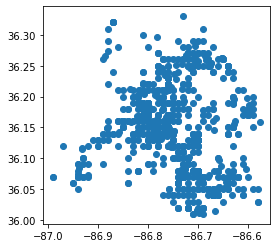

In [693]:
census_data_burglaries.plot()

In [690]:
chloropleth_data = pd.merge(census_tracts, census_data_burglaries, how = 'left') # all the rows from the left one are kept and 
# the right one will provide Nan for those ones it does not have a value for. 

<AxesSubplot:>

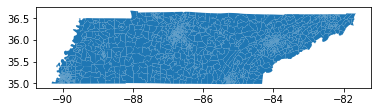

In [691]:
chloropleth_data.plot()

5. Finally, we'll build some statistical models to see how well we can explain the number of aggravated burglaries using the median income of each census tract. For this, we'll be using the [Generalized Linear Models](https://www.statsmodels.org/stable/glm.html) module of the statsmodels library.

    a. Build a "base model" - a Poisson regression model with just an intercept term with target variable the rate of burglaries per census tract. (Offset using the [log of the] population so that we are looking at the rate of burglaries per population instead of the number of burglaries.)

    b. Now, build a Poisson regression model with target variable the rate of burglaries and predictor variable the median income. (Don't forget to offset by the population).

    c. Finally, try out a negative binomial model. To get started with a negative binomial model, you can check out [this tutorial](https://timeseriesreasoning.com/contents/negative-binomial-regression-model/).

    d. How do your models compare? Hint: the fit models have an AIC attribute.



6. Prepare a short presentation (<10 minutes) of your findings.

Additional Resources for Generalized Linear Models:
* DataCamp - [Generalized Linear Models in Python](https://learn.datacamp.com/courses/generalized-linear-models-in-python)
* [Beyond Multiple Linear Regression, Chapter 4](https://bookdown.org/roback/bookdown-BeyondMLR/ch-poissonreg.html) Warning - the code in this book is all R, but the conceptual explanations are very clear.
* [This set of notes](https://apwheele.github.io/MathPosts/PoissonReg.html#negative-binomial-when-the-poisson-does-not-fit), which talks about the problem of overdispersion.